In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import csv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
import os
sys.path.append("../../../")

from relativewealth.feature_engineering import generate_features
from relativewealth.osm import get_osm_extent 
from scipy.stats import spearmanr
import geowrangler.vector_zonal_stats as vzs

## Load boundaries

In [4]:
id_hdx_adm2_filepath = Path('../../../data/idn_admbnda_adm2_bps_20200401.shp')
id_adm2_gdf = gpd.read_file(id_hdx_adm2_filepath)

# Get only the number in PCODE to match the comparison data
id_adm2_gdf['ADM2_PCODE'] = id_adm2_gdf['ADM2_PCODE'].str[2:].astype(str)
id_adm2_gdf.head(2)

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,2.360029,0.228968,Aceh Barat,1107,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"POLYGON ((96.26836 4.76800, 96.26822 4.76250, ..."
1,1.963994,0.154136,Aceh Barat Daya,1112,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7..."


## Load Indonesia model output

In [5]:
id_rollout_output_filepath = Path('../../2023-02-21-cross-country-rollouts/id/2023-02-21-id-rollout-output.geojson')
id_rollout_output_gdf = gpd.read_file(id_rollout_output_filepath)

In [6]:
id_rollout_output_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 161230 entries, 0 to 161229
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   quadkey                               161230 non-null  object  
 1   shapeName                             161230 non-null  object  
 2   shapeISO                              161230 non-null  object  
 3   shapeID                               161230 non-null  object  
 4   shapeGroup                            161230 non-null  object  
 5   shapeType                             161230 non-null  object  
 6   quadkey_level8                        161230 non-null  object  
 7   pop_count                             161230 non-null  float64 
 8   osm_region                            161230 non-null  object  
 9   Predicted Relative Wealth Index       161230 non-null  float64 
 10  Predicted Wealth Category (quintile)  161230 non

In [7]:
id_rollout_output_gdf['pop_count'].describe()

count    161230.000000
mean       1696.344622
std        5556.739326
min           1.279359
25%          41.478981
50%         275.124374
75%        1296.864624
max      162671.421875
Name: pop_count, dtype: float64

<AxesSubplot: >

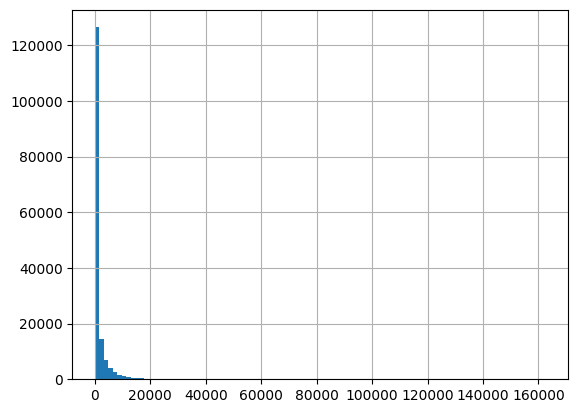

In [8]:
id_rollout_output_gdf['pop_count'].hist(bins=100)

### Aggregate the rollout output grids by ADM2

In [9]:
id_rollout_agg_by_adm2 = vzs.create_zonal_stats(
    id_adm2_gdf,
    id_rollout_output_gdf,
    overlap_method="intersects",
    aggregations=[
        {
            "column": "Predicted Relative Wealth Index",
            "func": "mean",
            "output": "model_wealth_index_mean",
        },
        {
            "column": "Predicted Relative Wealth Index",
            "func": "median",
            "output": "model_wealth_index_median",
        },

    ],
)


<AxesSubplot: >

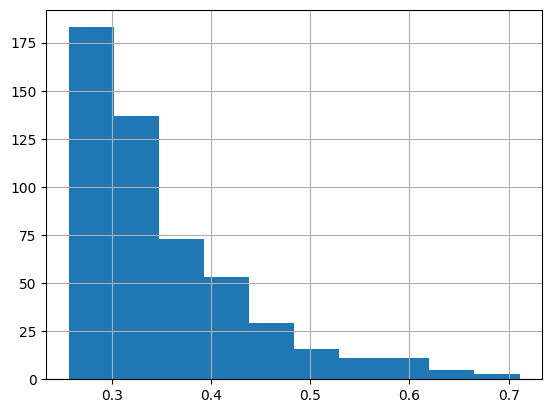

In [10]:
id_rollout_agg_by_adm2["model_wealth_index_mean"].hist()

In [11]:
# id_rollout_agg_by_adm2 = aggregate_grids_by_admin_bounds(
#     id_rollout_output_gdf, "indonesia", adm="ADM2", aggregations=aggregation
# )
# id_rollout_agg_by_adm2['rank'] = id_rollout_agg_by_adm2['model_wealth_index_median'].rank(ascending=False)

## Load comparison data for Indonesia

Note: The csv provided is dirty (has quotations for each line) so we have to clean it before loading as a dataframe

In [12]:
id_susenas_csv_filepath = Path('../../../data/20220706-IDN-Susenas Relative Wealth Index.csv')

In [13]:
# Input data is misformatted
# Read data line per line and store as dataframe
data_lines = []
with open(id_susenas_csv_filepath, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for i, row in enumerate(datareader):
        line = row[0]
        line = line.split(',')[1:]
        if i == 0:
            header = line
        else:
            data_lines.append(line)

id_susenas_df = pd.DataFrame(columns=header, data=data_lines)
id_susenas_df['ADM2_PCODE'] = id_susenas_df['ADM2_PCODE'].astype(str)
num_cols = ['wi_est_weighted', 'FWT', 'decile', 'percentile']
for col in num_cols:
    id_susenas_df[col] = pd.to_numeric(id_susenas_df[col])
id_susenas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ADM2_PCODE       513 non-null    object 
 1   wi_est_weighted  513 non-null    float64
 2   FWT              513 non-null    float64
 3   decile           513 non-null    int64  
 4   percentile       513 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 20.2+ KB


In [14]:
# Sense check
id_susenas_df.sort_values("wi_est_weighted", ascending=False).head(10)

,ADM2_PCODE,wi_est_weighted,FWT,decile,percentile
181,3275,2.976982,822795.057168,9,99
280,5171,2.845034,291766.005047,9,99
182,3276,2.831525,666770.841333,9,99
146,1971,2.822536,59100.144617,9,99
271,3674,2.769406,462216.548087,9,99
18,1171,2.744420,78648.391220,9,99
269,3672,2.728934,105039.098669,9,98
363,6474,2.703631,47393.633010,9,98
268,3671,2.698627,604716.086515,9,98
261,3577,2.651625,51633.042267,9,98


### Temporary Fix: Use HDX admin bounds file to attach the proper PCODE
The Indonesia comparison data has no geoms but has a PCODE, which we can use with the official admin boundaries from HDX

In [15]:
id_susenas_geoms_df = id_susenas_df.merge(id_adm2_gdf, how='left', on='ADM2_PCODE')
id_susenas_geoms_gdf = gpd.GeoDataFrame(id_susenas_geoms_df, geometry="geometry")
id_susenas_geoms_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 513 entries, 0 to 512
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ADM2_PCODE       513 non-null    object  
 1   wi_est_weighted  513 non-null    float64 
 2   FWT              513 non-null    float64 
 3   decile           513 non-null    int64   
 4   percentile       513 non-null    int64   
 5   Shape_Leng       513 non-null    float64 
 6   Shape_Area       513 non-null    float64 
 7   ADM2_EN          513 non-null    object  
 8   ADM2_REF         0 non-null      object  
 9   ADM2ALT1EN       0 non-null      object  
 10  ADM2ALT2EN       0 non-null      object  
 11  ADM1_EN          513 non-null    object  
 12  ADM1_PCODE       513 non-null    object  
 13  ADM0_EN          513 non-null    object  
 14  ADM0_PCODE       513 non-null    object  
 15  date             513 non-null    object  
 16  validOn          513 non-null    obj

<AxesSubplot: >

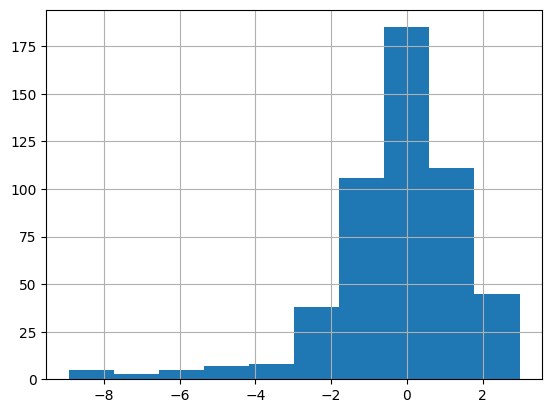

In [16]:
id_susenas_geoms_df['wi_est_weighted'].hist()

In [17]:
## Get rank


## Check ADM2_EN matches

In [18]:
id_susenas_area_names = id_susenas_geoms_gdf['ADM2_EN'].values.tolist()
id_rollout_agg_area_names = id_rollout_agg_by_adm2['ADM2_EN'].values.tolist()

In [19]:
no_matches = list(set(id_rollout_agg_area_names).difference(id_susenas_area_names))
no_matches

['Danau Toba',
 'Kepulauan Seribu',
 'Waduk Cirata',
 'Wadung Kedungombo',
 'Danau',
 'Hutan']

In [20]:
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

In [21]:
# 6 items in the rollout data (out of 519) don't have matches in the comparison data 
# We'll drop them in the final comparison
returnNotMatches(id_susenas_area_names, id_rollout_agg_area_names)

[[],
 ['Danau',
  'Danau',
  'Danau',
  'Danau',
  'Danau Toba',
  'Hutan',
  'Kepulauan Seribu',
  'Waduk Cirata',
  'Wadung Kedungombo']]

## Get rank correlation

In [22]:
# id_susenas_geoms_gdf['shapeName'] = id_susenas_geoms_gdf['ADM2_EN']
# id_susenas_geoms_gdf.head()

In [23]:
id_rollout_agg_by_adm2 = id_rollout_agg_by_adm2[~id_rollout_agg_by_adm2['ADM2_EN'].isin(no_matches)]
id_rollout_agg_by_adm2

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry,model_wealth_index_mean,model_wealth_index_median
0,2.360029,0.228968,Aceh Barat,1107,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"POLYGON ((96.26836 4.76800, 96.26822 4.76250, ...",0.306049,0.288863
1,1.963994,0.154136,Aceh Barat Daya,1112,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7...",0.344363,0.329475
2,4.590182,0.236396,Aceh Besar,1108,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2...",0.346366,0.326697
3,3.287754,0.316161,Aceh Jaya,1116,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"MULTIPOLYGON (((95.58431 4.61495, 95.58379 4.6...",0.298649,0.289465
4,4.448584,0.343038,Aceh Selatan,1103,None,None,None,Aceh,ID11,Indonesia,ID,2019-12-20,2020-04-01,None,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8...",0.313407,0.311266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,3.508874,0.297509,Way Kanan,1807,None,None,None,Lampung,ID18,Indonesia,ID,2019-12-20,2020-04-01,None,"POLYGON ((104.92793 -4.19234, 104.92823 -4.192...",0.312501,0.311106
518,2.718402,0.157671,Wonogiri,3312,None,None,None,Jawa Tengah,ID33,Indonesia,ID,2019-12-20,2020-04-01,None,"POLYGON ((111.18204 -7.71237, 111.18242 -7.712...",0.389461,0.385794
519,1.828518,0.081405,Wonosobo,3307,None,None,None,Jawa Tengah,ID33,Indonesia,ID,2019-12-20,2020-04-01,None,"POLYGON ((109.93000 -7.19465, 109.93017 -7.194...",0.385478,0.382874
520,5.771801,1.190892,Yahukimo,9416,None,None,None,Papua,ID94,Indonesia,ID,2019-12-20,2020-04-01,None,"POLYGON ((139.96223 -3.60980, 139.96314 -3.609...",0.269791,0.258099


In [24]:
compare_gdf = (
    id_rollout_agg_by_adm2[
        ["ADM2_EN", "ADM2_PCODE", "model_wealth_index_mean", "geometry"]
    ]
    .merge(
        id_susenas_geoms_gdf[["ADM2_EN", "ADM2_PCODE", "wi_est_weighted"]],
        on="ADM2_PCODE",
        how="inner",
        suffixes=["_model", "_reference"],
    )
    .dropna()
)
compare_gdf


,ADM2_EN_model,ADM2_PCODE,model_wealth_index_mean,geometry,ADM2_EN_reference,wi_est_weighted
0,Aceh Barat,1107,0.306049,"POLYGON ((96.26836 4.76800, 96.26822 4.76250, ...",Aceh Barat,1.212825
1,Aceh Barat Daya,1112,0.344363,"MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7...",Aceh Barat Daya,0.445685
2,Aceh Besar,1108,0.346366,"MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2...",Aceh Besar,1.449827
3,Aceh Jaya,1116,0.298649,"MULTIPOLYGON (((95.58431 4.61495, 95.58379 4.6...",Aceh Jaya,0.495084
4,Aceh Selatan,1103,0.313407,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8...",Aceh Selatan,0.767717
...,...,...,...,...,...,...
508,Way Kanan,1807,0.312501,"POLYGON ((104.92793 -4.19234, 104.92823 -4.192...",Way Kanan,-1.824709
509,Wonogiri,3312,0.389461,"POLYGON ((111.18204 -7.71237, 111.18242 -7.712...",Wonogiri,0.501210
510,Wonosobo,3307,0.385478,"POLYGON ((109.93000 -7.19465, 109.93017 -7.194...",Wonosobo,-1.914835
511,Yahukimo,9416,0.269791,"POLYGON ((139.96223 -3.60980, 139.96314 -3.609...",Yahukimo,-6.374596


In [25]:
compare_gdf['rank_reference'] = compare_gdf['wi_est_weighted'].rank(ascending=False)
compare_gdf['rank_model'] = compare_gdf['model_wealth_index_mean'].rank(ascending=False)

In [26]:
coef, p = spearmanr(compare_gdf['rank_reference'], compare_gdf['rank_model'])
coef, p

(0.7201497684711131, 3.68129491113764e-83)

In [27]:
# Top 10 based on reference
top10_adm2_reference = compare_gdf[['ADM2_EN_model', 'ADM2_PCODE','rank_reference', 'rank_model']].sort_values('rank_reference').head(10)
top10_adm2_reference

,ADM2_EN_model,ADM2_PCODE,rank_reference,rank_model
181,Kota Bekasi,3275,1.0,8.0
193,Kota Denpasar,5171,2.0,12.0
194,Kota Depok,3276,3.0,13.0
229,Kota Pangkal Pinang,1971,4.0,50.0
256,Kota Tangerang Selatan,3674,5.0,10.0
171,Kota Banda Aceh,1171,6.0,18.0
190,Kota Cilegon,3672,7.0,66.0
188,Kota Bontang,6474,8.0,95.0
255,Kota Tangerang,3671,9.0,7.0
212,Kota Madiun,3577,10.0,34.0


In [28]:
# Top 10 based on model
top10_adm2_reference = compare_gdf[['ADM2_EN_model', 'ADM2_PCODE', 'rank_model','rank_reference']].sort_values('rank_model').head(10)
top10_adm2_reference

,ADM2_EN_model,ADM2_PCODE,rank_model,rank_reference
199,Kota Jakarta Pusat,3173,1.0,18.0
200,Kota Jakarta Selatan,3171,2.0,15.0
198,Kota Jakarta Barat,3174,3.0,14.0
267,Kota Yogyakarta,3471,4.0,87.0
201,Kota Jakarta Timur,3172,5.0,11.0
202,Kota Jakarta Utara,3175,6.0,20.0
255,Kota Tangerang,3671,7.0,9.0
181,Kota Bekasi,3275,8.0,1.0
254,Kota Surakarta,3372,9.0,62.0
256,Kota Tangerang Selatan,3674,10.0,5.0


In [29]:
# Bottom 10 based on reference
bottom10_adm2_reference = compare_gdf[['ADM2_EN_model', 'ADM2_PCODE','rank_reference', 'rank_model']].sort_values('rank_reference').tail(10)

In [30]:
# Bottom 10 based on model
compare_gdf[['ADM2_EN_model', 'ADM2_PCODE', 'rank_model','rank_reference']].sort_values('rank_model').tail(10)

,ADM2_EN_model,ADM2_PCODE,rank_model,rank_reference
321,Mamberamo Tengah,9431,504.0,512.0
413,Puncak Jaya,9411,505.0,506.0
71,Boven Digoel,9413,506.0,387.0
412,Puncak,9433,507.0,503.0
391,Pegunungan Bintang,9417,508.0,500.0
124,Intan Jaya,9435,509.0,510.0
360,Nduga,9429,510.0,513.0
331,Mappi,9414,511.0,499.0
14,Asmat,9415,512.0,504.0
320,Mamberamo Raya,9428,513.0,491.0


## Heatmap

In [31]:
def despine(ax):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

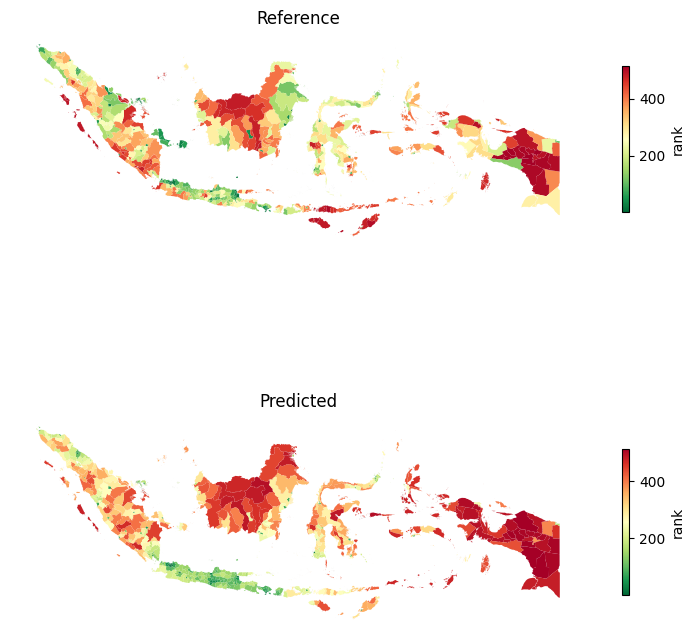

In [32]:
fig, axs = plt.subplots(2,1, figsize=(7.5,9))

compare_gdf.plot(
    column='rank_reference',
    ax=axs[0],
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={"shrink": 0.3, "label":"rank"},
)
despine(axs[0])

compare_gdf.plot(
    column='rank_model',
    ax=axs[1],
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={"shrink": 0.3, "label":"rank"},
)
despine(axs[1])
axs[0].set_title('Reference')
axs[1].set_title('Predicted')
fig.tight_layout()

## Get scatter plot

In [33]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

Text(0, 0.5, 'Model Wealth Rank')

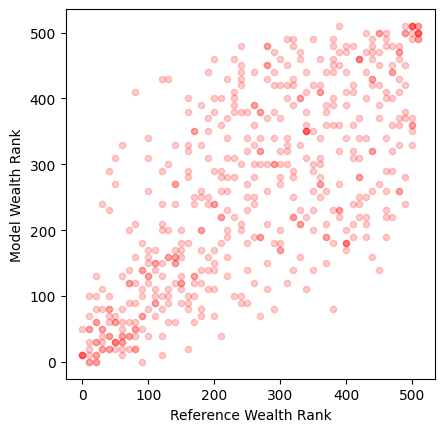

In [34]:
n=10
ranks_rounded_gdf = compare_gdf.copy()
ranks_rounded_gdf['rank_model'] = ranks_rounded_gdf['rank_model'].apply(lambda x: custom_round(x, base=n))
ranks_rounded_gdf['rank_reference'] = ranks_rounded_gdf['rank_reference'].apply(lambda x: custom_round(x, base=n))
ax = ranks_rounded_gdf.plot.scatter('rank_reference', 'rank_model', c='r', alpha=0.2)
ax.set_aspect('equal')
ax.set_xlabel("Reference Wealth Rank")
ax.set_ylabel("Model Wealth Rank")

<AxesSubplot: xlabel='rank_model', ylabel='rank_reference'>

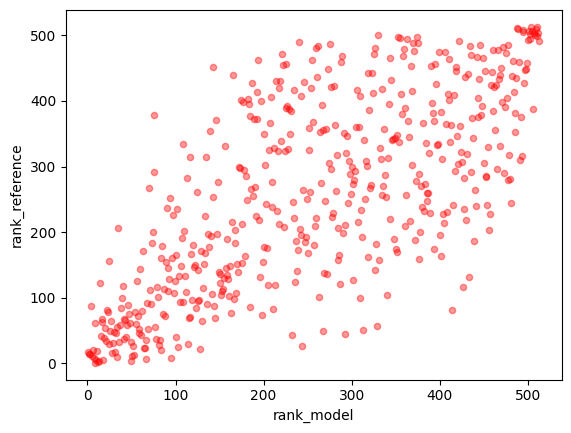

In [35]:
compare_gdf.plot.scatter('rank_model', 'rank_reference', c='r', alpha=0.4)

In [36]:
bottom_adm2_reference = compare_gdf[['ADM2_EN_model', 'ADM2_PCODE','rank_reference', 'rank_model']].sort_values('rank_reference').tail(30)

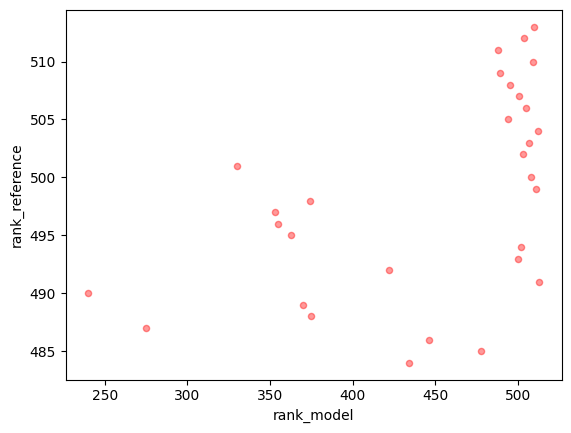

In [37]:
ax = bottom_adm2_reference.plot.scatter('rank_model', 'rank_reference', c='r', alpha=0.4)
# ax.set_xlim([450, 530])
# ax.set_ylim([450, 530])

## Explore per subarea ranking

In [38]:
len(id_rollout_agg_by_adm2['ADM1_EN'].unique())

34

In [39]:
import gc

area_list = list(id_rollout_agg_by_adm2['ADM1_EN'].unique())
area_spearmanr_list = []
for area in area_list:
    area_rollout_output = id_rollout_agg_by_adm2[id_rollout_agg_by_adm2['ADM1_EN'] == area].copy()
    # area_rollout_output['rank'] = area_rollout_output['model_wealth_index_mean'].rank(ascending=False)
    area_susenas_gdf = id_susenas_geoms_gdf[id_susenas_geoms_gdf['ADM1_EN'] == area].copy()
    # area_susenas_gdf['rank'] = area_susenas_gdf['wi_est_weighted'].rank(ascending=False)
    
    area_compare_gdf = (
        area_rollout_output[
            ["ADM2_EN", "ADM2_PCODE", "model_wealth_index_median", "geometry"]
        ]
        .merge(
            area_susenas_gdf[["ADM2_EN", "ADM2_PCODE", "wi_est_weighted"]],
            on="ADM2_PCODE",
            how="inner",
            suffixes=["_model", "_reference"],
        )
        .dropna()
    )

    area_compare_gdf['rank_reference'] = area_compare_gdf['wi_est_weighted'].rank(ascending=False)
    area_compare_gdf['rank_model'] = area_compare_gdf['model_wealth_index_mean'].rank(ascending=False)    

    coef, p = spearmanr(area_compare_gdf['rank_reference'], area_compare_gdf['rank_model'])
    print(f'{area} ({len(area_compare_gdf)}) -- Spearman Rank Correlation: {coef:.2} (p-value = {p:.2}) ')
    area_spearmanr_list.append(coef)
gc.collect()
# area_spearmanr_arr = np.array(area_spearmanr_list)
# plt.hist(area_spearmanr_arr)

spearman_by_area = pd.DataFrame({
    'ADM1_EN': area_list,
    'spearman_r': area_spearmanr_list
})
spearman_by_area= spearman_by_area.merge(id_adm2_gdf.dissolve('ADM1_EN'), how='left', on='ADM1_EN')
spearman_by_area = gpd.GeoDataFrame(spearman_by_area, geometry="geometry")
spearman_by_area['spearman_r'].hist(bins=10)

spearman_by_area.head()


KeyError: 'model_wealth_index_mean'

In [ ]:
spearman_by_area.loc[spearman_by_area['spearman_r'] < 0.5].sort_values('spearman_r')

,ADM1_EN,spearman_r,geometry,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo
32,Dki Jakarta,0.000000,"MULTIPOLYGON (((106.52018 -5.96011, 106.51991 ...",1.278015,0.000880,Kepulauan Seribu,3101,None,None,None,ID31,Indonesia,ID,2019-12-20,2020-04-01,None
19,Bengkulu,0.115152,"MULTIPOLYGON (((102.38683 -5.47139, 102.38707 ...",1.598399,0.099968,Bengkulu Selatan,1701,None,None,None,ID17,Indonesia,ID,2019-12-20,2020-04-01,None
25,Sulawesi Tenggara,0.250000,"MULTIPOLYGON (((121.93669 -5.49323, 121.93652 ...",5.421894,0.271792,Bombana,7406,None,None,None,ID74,Indonesia,ID,2019-12-20,2020-04-01,None
33,Sulawesi Barat,0.314286,"MULTIPOLYGON (((119.00584 -3.53308, 119.00442 ...",2.141557,0.072523,Majene,7601,None,None,None,ID76,Indonesia,ID,2019-12-20,2020-04-01,None
2,Nusa Tenggara Timur,0.341615,"MULTIPOLYGON (((119.54236 -9.75303, 119.54145 ...",5.513097,0.241630,Alor,5307,None,None,None,ID53,Indonesia,ID,2019-12-20,2020-04-01,None
6,Kalimantan Selatan,0.362637,"MULTIPOLYGON (((115.66627 -4.73677, 115.66653 ...",2.106946,0.154674,Balangan,6311,None,None,None,ID63,Indonesia,ID,2019-12-20,2020-04-01,None
12,Sulawesi Selatan,0.373913,"MULTIPOLYGON (((117.20300 -7.75854, 117.20286 ...",1.009615,0.032547,Bantaeng,7303,None,None,None,ID73,Indonesia,ID,2019-12-20,2020-04-01,None


In [ ]:
spearman_by_area

,ADM1_EN,spearman_r,geometry,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo
0,Aceh,0.500000,"MULTIPOLYGON (((95.28787 5.12890, 95.28796 5.1...",2.360029,0.228968,Aceh Barat,1107,None,None,None,ID11,Indonesia,ID,2019-12-20,2020-04-01,None
1,Sumatera Barat,0.685965,"MULTIPOLYGON (((99.53782 -2.22114, 99.53735 -2...",2.648821,0.181812,Agam,1307,None,None,None,ID13,Indonesia,ID,2019-12-20,2020-04-01,None
2,Nusa Tenggara Timur,0.341615,"MULTIPOLYGON (((119.54236 -9.75303, 119.54145 ...",5.513097,0.241630,Alor,5307,None,None,None,ID53,Indonesia,ID,2019-12-20,2020-04-01,None
3,Sumatera Utara,0.729612,"MULTIPOLYGON (((97.89210 -0.07667, 97.89186 -0...",3.592370,0.307542,Asahan,1208,None,None,None,ID12,Indonesia,ID,2019-12-20,2020-04-01,None
4,Papua,0.580296,"MULTIPOLYGON (((134.86427 -3.24425, 134.86404 ...",7.478910,2.041799,Asmat,9415,None,None,None,ID94,Indonesia,ID,2019-12-20,2020-04-01,None
5,Bali,0.833333,"MULTIPOLYGON (((115.12494 -8.84731, 115.12502 ...",2.337003,0.032441,Badung,5103,None,None,None,ID51,Indonesia,ID,2019-12-20,2020-04-01,None
6,Kalimantan Selatan,0.362637,"MULTIPOLYGON (((115.66627 -4.73677, 115.66653 ...",2.106946,0.154674,Balangan,6311,None,None,None,ID63,Indonesia,ID,2019-12-20,2020-04-01,None
7,Jawa Barat,0.741148,"MULTIPOLYGON (((107.42275 -7.50549, 107.42249 ...",3.093005,0.143607,Bandung,3204,None,None,None,ID32,Indonesia,ID,2019-12-20,2020-04-01,None
8,Sulawesi Tengah,0.681319,"MULTIPOLYGON (((121.36343 -1.94469, 121.36332 ...",7.415261,0.675995,Banggai,7202,None,None,None,ID72,Indonesia,ID,2019-12-20,2020-04-01,None
9,Kepulauan Bangka Belitung,0.964286,"MULTIPOLYGON (((106.51615 -3.13537, 106.51605 ...",3.607618,0.245180,Bangka,1901,None,None,None,ID19,Indonesia,ID,2019-12-20,2020-04-01,None


In [ ]:
spearman_by_area['spearman_r'].describe()

count    34.000000
mean      0.643037
std       0.232603
min       0.000000
25%       0.558710
50%       0.698039
75%       0.818452
max       0.964286
Name: spearman_r, dtype: float64

In [ ]:
# spearman_by_area.explore(
#     'spearman_r',
#     vmin=-0.7,
#     vmax=0.7,
#     cmap='RdYlGn'
# )